In [2]:
!pip install pytesseract
!pip install easyocr
!pip install mysql.connector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247952 sha256=83d648a183125d4da320f861a466fc28fcb8b863fb045a8d9f1de18f90b519d7
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177716d4a7d363d2bbe83bf6cf
Successfully built mysql.connector


No contour detected
License Plate Text: CCC 444


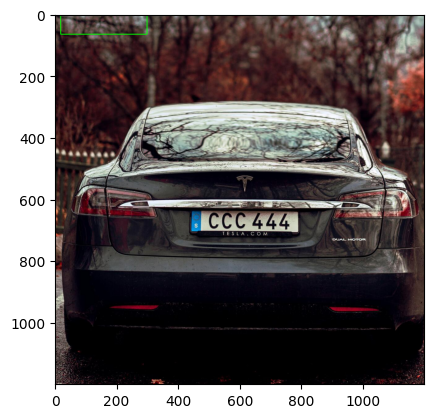

License Plate Text 'CCC 444' saved to recognized_license_plates1.csv


In [8]:
import numpy as np
import cv2 as cv
import imutils
import time
from matplotlib import pyplot as plt
import pytesseract as tess
import easyocr
import mysql.connector
import datetime
import sys
import re
import time
import requests
import pickle
import csv # Import the csv module
import os

# Load the license plate image (Assuming you already have the license_plate image)
image = cv.imread('20.jpg')
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

# Convert to grayscale
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))

#Remove Noise using Gausian Blur
blur = cv.GaussianBlur(gray, (5,5), 0)
plt.imshow(cv.cvtColor(blur, cv.COLOR_BGR2RGB))

# Detect edges using Canny
edged = cv.Canny(blur, 10, 200)
plt.imshow(cv.cvtColor(edged, cv.COLOR_BGR2RGB))

# Find contours and extract the license plate region
contours, _ = cv.findContours(edged, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv.contourArea, reverse = True)[:5]
n_plate_cnt = None
    # loop over the contours
for c in contours:
    # approximate each contour
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.02 * peri, True)
    # if the contour has 4 points, we can say
    # that we have found our license plate
    if len(approx) == 4:
        n_plate_cnt = approx
        break
    if  n_plate_cnt is None:
     detected = 0
     print ("No contour detected")
# get the bounding box of the contour and
# extract the license plate from the image
(x, y, w, h) = cv.boundingRect(n_plate_cnt)
license_plate = gray[y:y + h, x:x + w]

# Display the license plate image
plt.imshow(license_plate)

# Use EasyOCR to recognize text in the license plate image
reader = easyocr.Reader(['en'])  # Create an EasyOCR reader for English text
result = reader.readtext(license_plate)

# Print the recognized text
if result:
    license_plate_text = result[0][1]
    print("License Plate Text:", license_plate_text)
else:
    print("No text detected on the license plate")

# Show the license plate image with bounding boxes and recognized text
for (bbox, text, prob) in result:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    cv.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    cv.putText(image, text, (top_left[0], top_left[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Display the annotated image with recognized text
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

# Save the recognized license plate text to a CSV file
csv_file = 'recognized_license_plates1.csv'

# Check if the file already exists, if not, create the CSV file with a header
header = ['Timestamp', 'License Plate Text']
if not os.path.isfile(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

# Get the current timestamp
timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# Append the recognized license plate text and timestamp to the CSV file
data = [timestamp, license_plate_text]
with open(csv_file, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(data)

print(f"License Plate Text '{license_plate_text}' saved to {csv_file}")
